In [1]:
!pip install matplotlib
!pip install scipy
#This abandoned version is after only freezing the first 9/10 layers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os


import keras
from keras import Model
import keras.layers as layers
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from keras.callbacks import TensorBoard, EarlyStopping
from keras.utils import image_dataset_from_directory, Sequence
from keras.preprocessing.image import ImageDataGenerator

from keras import datasets
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-03-21 18:25:07.324108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 18:25:07.482570: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 18:25:08.176099: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-21 18:25:08.176190: W tensorflow/

In [2]:
img_train_path = os.path.join("DATASET","TRAIN")
img_test_path = os.path.join("DATASET","TEST")
img_SET1_path = os.path.join("DATASET","CROSS/SET1")
img_SET2_path = os.path.join("DATASET","CROSS/SET2")
img_SET3_path = os.path.join("DATASET","CROSS/SET3")
img_SET1_SET2_path = os.path.join("DATASET","CROSS/SET1_SET2")
img_SET1_SET3_path = os.path.join("DATASET","CROSS/SET1_SET3")
img_SET2_SET3_path = os.path.join("DATASET","CROSS/SET2_SET3")

data_gen = ImageDataGenerator(rescale=1./255, fill_mode='reflect')
BATCH_SIZE = 128

raw_generator = data_gen.flow_from_directory(img_train_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET1_generator = data_gen.flow_from_directory(img_SET1_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET2_generator = data_gen.flow_from_directory(img_SET2_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET3_generator = data_gen.flow_from_directory(img_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET1_generator = data_gen.flow_from_directory(img_SET1_SET2_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET2_generator = data_gen.flow_from_directory(img_SET1_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET3_generator = data_gen.flow_from_directory(img_SET2_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
test_generator = data_gen.flow_from_directory(img_test_path, target_size=(256,256), batch_size=BATCH_SIZE)

Found 22564 images belonging to 2 classes.
Found 7447 images belonging to 2 classes.
Found 7672 images belonging to 2 classes.
Found 7445 images belonging to 2 classes.
Found 15119 images belonging to 2 classes.
Found 14892 images belonging to 2 classes.
Found 15117 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [3]:
img, _= next(raw_generator)
print(img.shape)

(128, 256, 256, 3)


In [4]:
def rebuild_model():
    global pretrained_model
    global model
    pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

    #freezing layers
    len_trainable_layers = int((9/10*len(pretrained_model.layers)))
    for layer in pretrained_model.layers[0:len_trainable_layers]:
        layer.trainable = False
    model = keras.Sequential()

    model.add(pretrained_model)

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'], jit_compile=True)
rebuild_model()
pretrained_model.summary()

2023-03-21 18:25:11.732746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 18:25:11.778629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 18:25:11.778877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 18:25:11.780908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 18:25:11.781097: I tensorflow/compiler/xla/stream_executo

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
          

 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

In [6]:
# reduce time and overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 24,801,282
Trainable params: 9,094,786
Non

Epoch 1/15


2023-03-21 18:25:24.826930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-21 18:25:26.852413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 18:25:26.974929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
 

  2/118 [..............................] - ETA: 12s - loss: 1.1315 - accuracy: 0.5078  

2023-03-21 18:25:30.353033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 93/118 [======================>.......] - ETA: 6s - loss: 0.5289 - accuracy: 0.7447

2023-03-21 18:25:56.707764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 18:25:56.723867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

118/118 [==============================] - 65s 451ms/step - loss: 0.5135 - accuracy: 0.7547 - val_loss: 14.3312 - val_accuracy: 0.5603
Epoch 2/15
118/118 [==============================] - 46s 388ms/step - loss: 0.4459 - accuracy: 0.8001 - val_loss: 2.2298 - val_accuracy: 0.6517
Epoch 3/15
118/118 [==============================] - 48s 408ms/step - loss: 0.4156 - accuracy: 0.8152 - val_loss: 0.6541 - val_accuracy: 0.7870
Epoch 4/15
118/118 [==============================] - 48s 406ms/step - loss: 0.4045 - accuracy: 0.8209 - val_loss: 1.9153 - val_accuracy: 0.6332
Epoch 5/15
118/118 [==============================] - 45s 383ms/step - loss: 0.3880 - accuracy: 0.8308 - val_loss: 0.9008 - val_accuracy: 0.6804
Epoch 6/15
118/118 [==============================] - 46s 388ms/step - loss: 0.3733 - accuracy: 0.8366 - val_loss: 0.8305 - val_accuracy: 0.6917
Epoch 7/15
118/118 [==============================] - 45s 382ms/step - loss: 0.3626 - accuracy: 0.8408 - val_loss: 0.7604 - val_accuracy: 0.

2023-03-21 18:37:15.158356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 81 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 18:37:15.240126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 81 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

20/20 [==============================] - 8s 401ms/step - loss: 1.3257 - accuracy: 0.6132
test loss, test acc: [1.3256782293319702, 0.6132112741470337]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


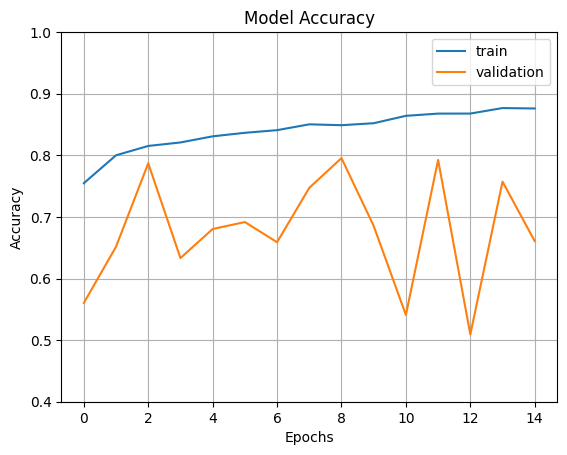

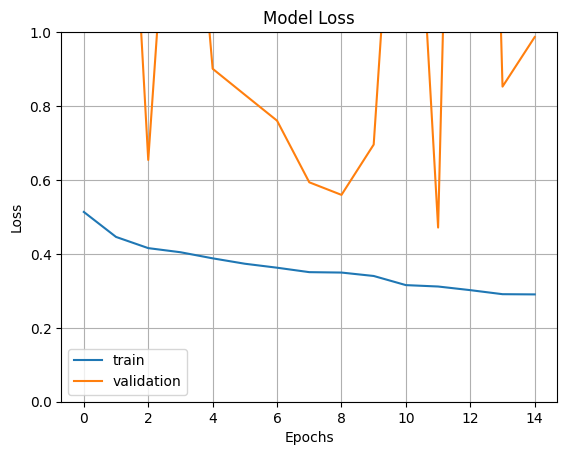

In [7]:
train_generator = CSET1_generator
validation_generator = SET3_generator

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

len_trainable_layers = int((9/10*len(pretrained_model.layers)))
for layer in pretrained_model.layers[0:len_trainable_layers]:
    layer.trainable = False
        
model = keras.Sequential()

model.add(pretrained_model)

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'], jit_compile=True)

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#bad result

In [8]:
train_generator = CSET2_generator
validation_generator = SET2_generator

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

len_trainable_layers = int((9/10*len(pretrained_model.layers)))
for layer in pretrained_model.layers[0:len_trainable_layers]:
    layer.trainable = False
        
model = keras.Sequential()

model.add(pretrained_model)

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'], jit_compile=True)

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Epoch 1/15
 61/116 [==============>...............] - ETA: 14s - loss: 0.5800 - accuracy: 0.7099

KeyboardInterrupt: 

In [ ]:
train_generator =  CSET3_generator
validation_generator = SET1_generator

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

len_trainable_layers = int((9/10*len(pretrained_model.layers)))
for layer in pretrained_model.layers[0:len_trainable_layers]:
    layer.trainable = False
        
model = keras.Sequential()

model.add(pretrained_model)

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'], jit_compile=True)

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
img, _= next(test_generator)
plt.figure(figsize=(15, 13))
result = model.predict(img)
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    if result[i][1] < 0.5:
        pred = 0
        if pred == _[i][1]:
            plt.title("Organic", color='green')
        else: 
            plt.title("Organic", color='red')
    else:
        pred = 1
        if pred == _[i][1]:
            plt.title("Non-Organic", color='green')
        else: 
            plt.title("Non-Organic", color='red')
    plt.axis("off")